# Regression & Classification with _Bayesian Neural Network_ in PyTorch

Using ```torchbnn``` package.

- [Coding reference](https://signing.tistory.com/92)

- [bayesian neural network PyTorch github](https://github.com/Harry24k/bayesian-neural-network-pytorch)

- [torchbnn Documentation](https://bayesian-neural-network-pytorch.readthedocs.io/_/downloads/en/latest/pdf/)

- [BLiTZ — A Bayesian Neural Network library for PyTorch](https://towardsdatascience.com/blitz-a-bayesian-neural-network-library-for-pytorch-82f9998916c7)

- [BLiTZ documentation](https://github.com/piEsposito/blitz-bayesian-deep-learning#Documentation)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchbnn as bnn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


### Bayesian Regression

#### Generate random data

The data is generated using the equation: $y=x^3+x^2+3\times\epsilon$ where $\epsilon$ is random noise.

In [5]:
x = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3 * torch.rand(x.size())

In [6]:
x.shape, y.shape

(torch.Size([500]), torch.Size([500]))

In [7]:
x = torch.unsqueeze(x, dim = 1)
y = torch.unsqueeze(y, dim = 1)

In [8]:
x.shape, y.shape

(torch.Size([500, 1]), torch.Size([500, 1]))

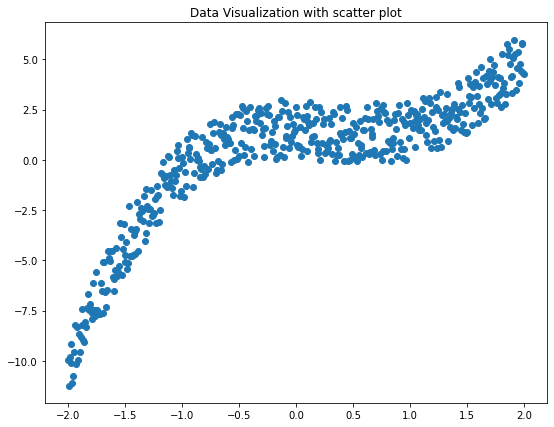

In [9]:
plt.figure(figsize = (9, 7))
plt.scatter(x.data.numpy(), y.data.numpy())
plt.title("Data Visualization with scatter plot")
plt.show()

### Define _Bayesian_ Neural Network architecture for _Regression_

1. The BNN regressor has one single fully-connected layer having 100 neurons in it.

1. But since this layer is a Bayeisna Neural Network, the weights do not have fixed values but rather distributions. Hence, ```BayesLinear``` layer is used.

1. ```prior_mu``` and ```prior_sigma``` are parameters for defining the Gaussian distribution because the distribution has already been set to be a Gaussian.

In [10]:
class Bayes_NN_Regressor(nn.Module):
    def __init__(self):
        super(Bayes_NN_Regressor, self).__init__()
        
        self.bayes_dense_1 = bnn.BayesLinear(
            prior_mu = 0.0, prior_sigma = 1.0,
            in_features = 1, out_features = 100
        )
        
        self.bayes_dense_2 = bnn.BayesLinear(
            prior_mu = 0.0, prior_sigma = 1.0,
            in_features = 100, out_features = 1
        )
        
    def forward(self, x):
        x = x = F.relu(self.bayes_dense_1(x))
        x = self.bayes_dense_2(x)
        return x
    

In [11]:
# Initialize an instance of Bayes NN regressor-
model = Bayes_NN_Regressor().to(device)

In [12]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([100, 1]) has 100 parameters
layer.shape = torch.Size([100, 1]) has 100 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([1, 100]) has 100 parameters
layer.shape = torch.Size([1, 100]) has 100 parameters
layer.shape = torch.Size([1]) has 1 parameters
layer.shape = torch.Size([1]) has 1 parameters


In [13]:
print(f"Total number of parameters in Bayes Neural Network regressor model = {tot_params}")

Total number of parameters in Bayes Neural Network regressor model = 602


In [14]:
# Sanity check-
pred = model(x[:5, :])

In [15]:
x[:5, :].shape, pred.shape

(torch.Size([5, 1]), torch.Size([5, 1]))

In [16]:
del pred

#### Define losses for BNN

The parameters of ```BKLLoss``` function are:

1. ```reduction```: Specifies the reduction to be applied to the output. Other reductions include: 'mean' and 'sum'.

1. ```last_layer_only```: True for returning only the last layer's KL-divergence.

In [17]:
# Mean-squared error loss-
mse_loss = nn.MSELoss()

# Loss for calculating KL-divergence of BNN regressor model-
kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

In [18]:
# Use Adam gradient descent optimizer-
optimizer = optim.Adam(model.parameters(), lr = 0.01)

### Train BNN regressor

In [19]:
# KL-divergence term: Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
kl_weight = 1

In [20]:
# Python3 dict to contain losses-
bnn_losses = {}

In [21]:
for step in range(3000):
    # Make predictions-
    pred = model(x)
    
    # Compute MSE error-
    mse = mse_loss(pred, y)
    
    # Compute KL-divergence loss-
    kl = kl_loss(model)
    
    # Compute total cost-
    total_cost = mse + (kl_weight * kl)
    
    # Empty accumulated gradients-
    optimizer.zero_grad()
    
    # Perform gradient descent-
    total_cost.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(f"step: {step:.4f}, total cost: {total_cost.detach().numpy()[0]:.4f}"
              f", KL-div loss = {kl.detach().numpy()[0]:.4f} & "
              f"MSE = {mse.detach().numpy():.4f}"
             )
    
    # Store in dict-
    bnn_losses[step] = {
        'total_cost': total_cost.detach().numpy(), 'kl_loss': kl.detach().numpy()[0],
        'mse': mse.detach().numpy()
    }
    


step: 0.0000, total cost: 37.9325, KL-div loss = 0.1073 & MSE = 37.8252
step: 100.0000, total cost: 157.2941, KL-div loss = 0.1118 & MSE = 157.1823
step: 200.0000, total cost: 9.3306, KL-div loss = 0.1303 & MSE = 9.2002
step: 300.0000, total cost: 36.7430, KL-div loss = 0.1474 & MSE = 36.5956
step: 400.0000, total cost: 83.6633, KL-div loss = 0.1715 & MSE = 83.4918
step: 500.0000, total cost: 36.5386, KL-div loss = 0.1936 & MSE = 36.3450
step: 600.0000, total cost: 14.6762, KL-div loss = 0.2163 & MSE = 14.4599
step: 700.0000, total cost: 15.1007, KL-div loss = 0.2350 & MSE = 14.8657
step: 800.0000, total cost: 18.9512, KL-div loss = 0.2536 & MSE = 18.6976
step: 900.0000, total cost: 11.4231, KL-div loss = 0.2771 & MSE = 11.1460
step: 1000.0000, total cost: 4.3836, KL-div loss = 0.2953 & MSE = 4.0883
step: 1100.0000, total cost: 12.8201, KL-div loss = 0.3155 & MSE = 12.5046
step: 1200.0000, total cost: 15.8504, KL-div loss = 0.3328 & MSE = 15.5176
step: 1300.0000, total cost: 15.8840, K

### Visualize BNN training

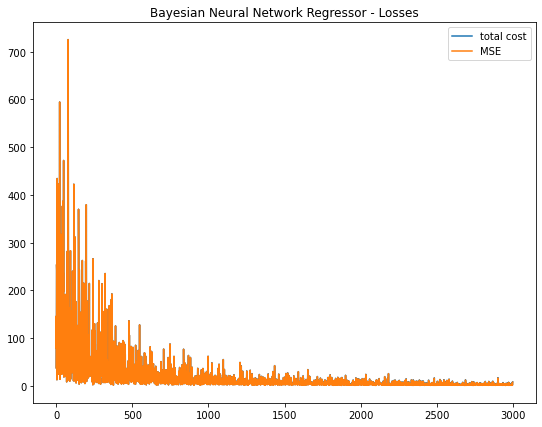

In [22]:
plt.figure(figsize = (9, 7))
plt.plot([bnn_losses[s]['total_cost'] for s in bnn_losses.keys()], label = 'total cost')
plt.plot([bnn_losses[s]['mse'] for s in bnn_losses.keys()], label = 'MSE')
plt.title("Bayesian Neural Network Regressor - Losses")
plt.legend(loc = 'best')
plt.show()

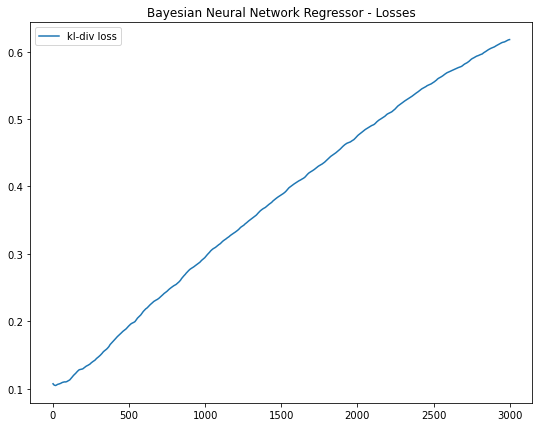

In [23]:
plt.figure(figsize = (9, 7))
plt.plot([bnn_losses[s]['kl_loss'] for s in bnn_losses.keys()], label = 'kl-div loss')
plt.title("Bayesian Neural Network Regressor - Losses")
plt.legend(loc = 'best')
plt.show()

### Test trained BNN regressor

In [24]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3 * torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim = 1)
y_test = torch.unsqueeze(y_test, dim = 1)

In [25]:
x_test.shape, y_test.shape

(torch.Size([500, 1]), torch.Size([500, 1]))

### Visualize BNN output

- The result of training by generating three outputs can be visualized below. Each time, we get a different model.

- It is a different model with very slight differences.

- This is so __due to BNN where the weights exist as distributions__.

- Even with the same input, the result is different each time.

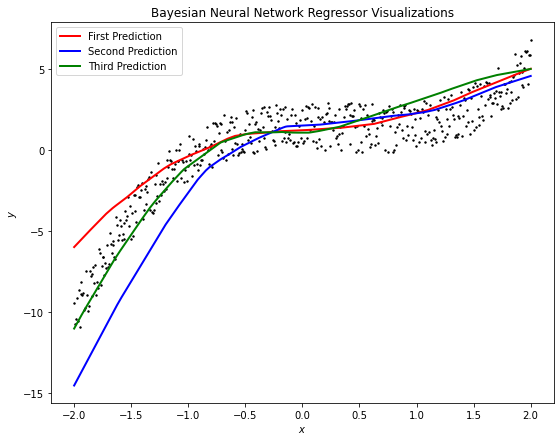

In [26]:
# Visualize true vs. predicted values-
plt.figure(figsize = (9, 7))

# First prediction-
y_predict = model(x_test)
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color = 'k', s = 2)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth = 2, label = 'First Prediction')

# Second prediction-
y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth = 2, label = 'Second Prediction')

# Third prediction-
y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth = 2, label = 'Third Prediction')

plt.legend(loc = 'best')
plt.title("Bayesian Neural Network Regressor Visualizations")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Bayesian Neural Networks Classification

With _Iris_ dataset.

In [5]:
# Get Iris dataset for classification-
iris = load_iris()
X = iris.data
Y = iris.target

In [6]:
X.shape, Y.shape

((150, 4), (150,))

In [7]:
# Scale features-
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

In [8]:
# Sanity check-
X.shape, X_scaled.shape

((150, 4), (150, 4))

In [9]:
# Sanity check-
X_scaled.min(), X_scaled.max()

(-2.43394714190809, 3.0907752482994253)

In [10]:
# Split into train and test sets-
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size = 0.2
)

In [11]:
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (120, 4), y_train.shape: (120,)
X_test.shape: (30, 4), y_test.shape: (30,)


In [12]:
# Convert to float values-
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float().long()
y_test = torch.from_numpy(y_test).float().long()

In [13]:
# Sanity check-
X_train[:5, :], y_train[:5]

(tensor([[-5.2506e-02, -8.2257e-01,  8.0709e-02,  8.7755e-04],
         [-1.0218e+00, -2.4339e+00, -1.4664e-01, -2.6239e-01],
         [-1.1430e+00, -1.5132e+00, -2.6032e-01, -2.6239e-01],
         [ 1.8983e-01, -1.3198e-01,  5.9225e-01,  7.9067e-01],
         [-1.3854e+00,  3.2841e-01, -1.2266e+00, -1.3154e+00]]),
 tensor([1, 1, 1, 2, 0]))

In [14]:
X_test[:5, :], y_test[:5]

(tensor([[-0.9007,  1.7096, -1.0560, -1.0522],
         [ 1.4015,  0.3284,  0.5354,  0.2641],
         [ 1.7650, -0.3622,  1.4448,  0.7907],
         [-1.1430,  0.0982, -1.2834, -1.3154],
         [-0.4160,  2.6304, -1.3402, -1.3154]]),
 tensor([0, 1, 2, 0, 0]))

In [15]:
class Bayes_NN_Classifier(nn.Module):
    def __init__(self):
        super(Bayes_NN_Classifier, self).__init__()
        
        self.bayes_dense_1 = bnn.BayesLinear(
            prior_mu = 0.0, prior_sigma = 1.0,
            in_features = 4, out_features = 100
        )
        
        self.bayes_dense_2 = bnn.BayesLinear(
            prior_mu = 0.0, prior_sigma = 1.0,
            in_features = 100, out_features = 3
        )
        
    def forward(self, x):
        x = x = F.relu(self.bayes_dense_1(x))
        x = self.bayes_dense_2(x)
        return x
    

In [16]:
# Initialize an instance-
model = Bayes_NN_Classifier().to(device)

In [17]:
# Sanity check-
pred = model(X_train[:5, :])

In [18]:
pred.shape, y_train[:5].shape

(torch.Size([5, 3]), torch.Size([5]))

In [19]:
pred

tensor([[  0.0584,   5.4323,  -7.3059],
        [  3.5815,  10.8913, -20.0326],
        [  7.1695,   7.5820, -10.3725],
        [ 12.7823,   0.7344, -22.6335],
        [ 10.2763,  20.0217, -10.3257]], grad_fn=<AddmmBackward0>)

In [20]:
del pred

In [21]:
# Cross-entropy loss-
ce_loss = nn.CrossEntropyLoss()

# Loss for calculating KL-divergence of BNN regressor model-
kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

In [22]:
# Use Adam gradient descent optimizer-
optimizer = optim.Adam(model.parameters(), lr = 0.01)

### Train BNN classifier

In [23]:
# KL-divergence term: Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
kl_weight = 1

In [24]:
# Python3 dict to contain losses-
bnn_losses = {}

In [25]:
# Train neural network using Batch Gradient Descent-
for epoch in range(3000):
    # Make predictions-
    pred = model(X_train)
    
    # Compute Cross-entropy error-
    ce = ce_loss(pred, y_train)
    
    # Compute KL-divergence loss-
    kl = kl_loss(model)
    
    # Compute total cost-
    total_cost = ce + (kl_weight * kl)
    
    # Empty accumulated gradients-
    optimizer.zero_grad()
    
    # Perform gradient descent-
    total_cost.backward()
    optimizer.step()
    
    # Calculate accuracy-
    _, predicted = torch.max(pred.data, 1)
    total = y_train.size(0)
    correct = (predicted == y_train).sum()
    
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch}, total cost: {total_cost.detach().numpy()[0]:.4f}"
              f", KL-div loss = {kl.detach().numpy()[0]:.4f}, "
              f"Cross-entropy loss = {ce.detach().numpy():.4f}"
              f" & accuracy = {100 * float(correct) / total:.2f}%"
             )
    
    # Store in dict-
    bnn_losses[epoch] = {
        'total_cost': total_cost.detach().numpy(), 'kl_loss': kl.detach().numpy()[0],
        'ce_loss': ce.detach().numpy(), 'acc': 100 * float(correct) / total
    }
    


epoch: 0, total cost: 3.0340, KL-div loss = 0.0278, Cross-entropy loss = 3.0061 & accuracy = 57.50%
epoch: 100, total cost: 16.2144, KL-div loss = 0.0504, Cross-entropy loss = 16.1640 & accuracy = 35.00%
epoch: 200, total cost: 1.4405, KL-div loss = 0.0842, Cross-entropy loss = 1.3563 & accuracy = 71.67%
epoch: 300, total cost: 1.1238, KL-div loss = 0.1163, Cross-entropy loss = 1.0075 & accuracy = 70.83%
epoch: 400, total cost: 2.7063, KL-div loss = 0.1410, Cross-entropy loss = 2.5654 & accuracy = 65.00%
epoch: 500, total cost: 1.5906, KL-div loss = 0.1600, Cross-entropy loss = 1.4306 & accuracy = 81.67%
epoch: 600, total cost: 0.9767, KL-div loss = 0.1746, Cross-entropy loss = 0.8021 & accuracy = 89.17%
epoch: 700, total cost: 0.7307, KL-div loss = 0.1959, Cross-entropy loss = 0.5349 & accuracy = 82.50%
epoch: 800, total cost: 1.2320, KL-div loss = 0.2124, Cross-entropy loss = 1.0196 & accuracy = 74.17%
epoch: 900, total cost: 0.4691, KL-div loss = 0.2277, Cross-entropy loss = 0.2415 

### Visualize BNN training

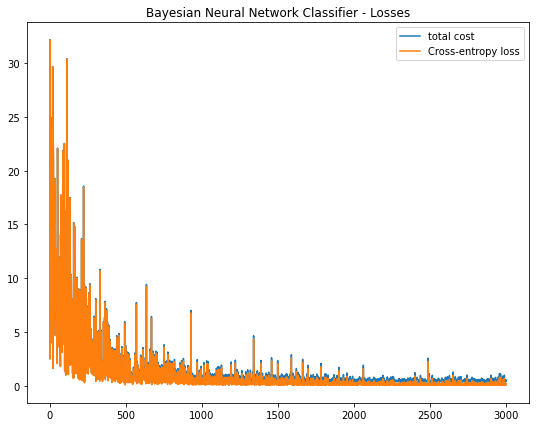

In [26]:
plt.figure(figsize = (9, 7))
plt.plot([bnn_losses[s]['total_cost'] for s in bnn_losses.keys()], label = 'total cost')
plt.plot([bnn_losses[s]['ce_loss'] for s in bnn_losses.keys()], label = 'Cross-entropy loss')
plt.title("Bayesian Neural Network Classifier - Losses")
plt.legend(loc = 'best')
plt.show()

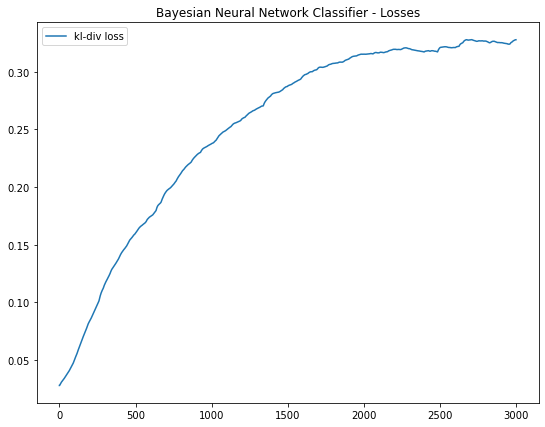

In [27]:
plt.figure(figsize = (9, 7))
plt.plot([bnn_losses[s]['kl_loss'] for s in bnn_losses.keys()], label = 'kl-div loss')
plt.title("Bayesian Neural Network Classifier - Losses")
plt.legend(loc = 'best')
plt.show()

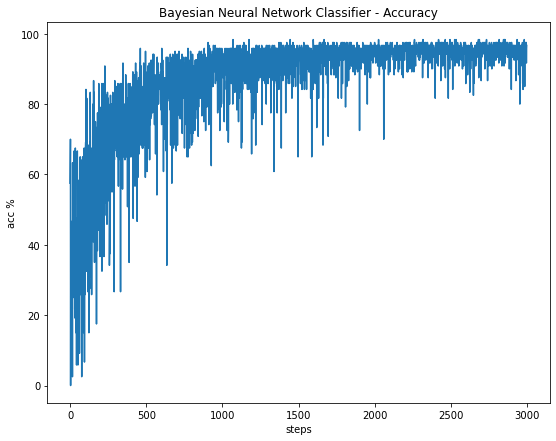

In [28]:
plt.figure(figsize = (9, 7))
plt.plot([bnn_losses[s]['acc'] for s in bnn_losses.keys()])
plt.title("Bayesian Neural Network Classifier - Accuracy")
plt.xlabel("steps")
plt.ylabel("acc %")
# plt.legend(loc = 'best')
plt.show()

In [29]:
# Make predictions using trained model-
y_pred = model(X_test)

In [30]:
y_pred.shape, y_test.shape

(torch.Size([30, 3]), torch.Size([30]))

In [33]:
_, y_pred = torch.max(y_pred, 1)

In [34]:
# Compute metrics on validation data-
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
rec = recall_score(y_true = y_test, y_pred = y_pred, average = 'macro')
prec = precision_score(y_true = y_test, y_pred = y_pred, average = 'macro')

In [36]:
print("Validation data metrics:")
print(f"accuracy = {acc * 100:.2f}%, precision = {prec * 100:.2f}% &"
      f" recall = {rec * 100:.2f}%")

Validation data metrics:
accuracy = 100.00%, precision = 100.00% & recall = 100.00%


In [37]:
print(f"Confusion matrix:\n{confusion_matrix(y_true = y_test, y_pred = y_pred)}")

Confusion matrix:
[[ 8  0  0]
 [ 0 11  0]
 [ 0  0 11]]


In [38]:
# Save trained BNN classifier model's weights-
torch.save(model.state_dict(), 'BNN_Iris_Classifier_trained.pth')

In [39]:
# Sanity check.
# Load trained weights from before-
loaded_model = Bayes_NN_Classifier().to(device)
loaded_model.load_state_dict(torch.load('BNN_Iris_Classifier_trained.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

In [40]:
# Make predictions using trained & loaded model-
pred = loaded_model(X_test)

In [41]:
_, predicted = torch.max(pred.data, 1)
total = y_test.size(0)
correct = (predicted == y_test).sum()

In [42]:
print(f"Accuracy = {correct/total * 100:.2f}%")

Accuracy = 90.00%


In [43]:
del loaded_model

In [44]:
import pickle

# Save training history as pickle file-
with open("BNN_Iris_classifier_training_history.pkl", "wb") as file:
    pickle.dump(bnn_losses, file)

### NOTE: _Batch Gradient Descent_ is used instead of _Mini-Batch Gradient Descent_ for the examples above.